# OPERA Surface Displacement from Sentinel-1: Access and Visualize

Authors: Harshini Girish (UAH), Rajat Shinde (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed), Julia Signell (Element84)

Date:July 28, 2025

Description: This tutorial aims to provide information and code to help users get started working with the OPERA Sentinel-1 Surface Displacement product using the MAAP. We will search for the data within NASA’s Common Metadata Repository (CMR).

## Run This Notebook

To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the “Getting started with the MAAP” section of our documentation.

Disclaimer: It is highly recommended that you run this tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.



## About the Data

> The Level-3 OPERA Sentinel-1 Surface Displacement (DISP) product is generated through interferometric time-series analysis of Level-2 Coregistered Sentinel-1 Single Look Complex (CSLC) datasets. Using a hybrid Persistent Scatterer (PS) and Distributed Scatterer (DS) approach, this product quantifies Earth's surface displacement in the radar line-of-sight. The DISP products enable the detection of anthropogenic and natural surface changes, including subsidence, tectonic deformation, and landslides. 

> The OPERA DISP suite comprises complementary datasets derived from Sentinel-1 and NISAR inputs, designated as DISP-S1 and DISP-NI, respectively. Each product, created per acquisition, adheres to a consistent structure, HDF5 file format, file-naming convention, and a 30 m spatial posting. This collection specifically includes DISP-S1 products, derived from Sentinel-1 data. For visualization and quick exploration, the Pangeo Image can be used for these datasets. 


Source: [OPERA Surface Displacement from Sentinel-1](https://cmr.earthdata.nasa.gov/search/concepts/C3294057315-ASF.html)

## Importing Packages

In [3]:
# --- MAAP & Cloud Access ---
from maap.maap import MAAP
import earthaccess
from s3fs import S3FileSystem

# File Access & Processing -
import os
import fsspec
import h5py
import re
import numpy as np
import xarray as xr
import dask

# Plotting & Visualization 
import matplotlib.pyplot as plt
import folium

#  Geospatial 
import geopandas as gpd
from shapely.geometry import box, Polygon

# Misc
import requests

# Initialize MAAP
maap = MAAP()


## Searching the Data

This performs a granule search using the `maap.searchGranule()` function on the OPERA Sentinel-1 displacement product collection.

In [16]:
collection = maap.searchCollection(
    cmr_host="cmr.earthdata.nasa.gov",
    short_name="OPERA_L3_DISP-S1_V1"
)
len(collection)



1

In [17]:
results = maap.searchGranule(
    short_name="OPERA_L3_DISP-S1_V1",
    cmr_host="cmr.earthdata.nasa.gov",
    limit=100
)

records = []
for r in results:
    granule = r["Granule"]
    try:
        points = granule["Spatial"]["HorizontalSpatialDomain"]["Geometry"]["GPolygon"]["Boundary"]["Point"]
        coords = [(float(p["PointLongitude"]), float(p["PointLatitude"])) for p in points]
        if len(coords) >= 3:
            polygon = Polygon(coords)
            records.append({
                "GranuleUR": granule["GranuleUR"],
                "geometry": polygon
            })
    except KeyError:
        continue
if records:
    gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")
    print(f"Found {len(gdf)} granules with polygons.")

    

Found 100 granules with polygons.


## Visualizing with Bounding Boxes

This code creates an interactive map showing bounding boxes for each granule using `folium`. It extracts geometry bounds from a `GeoDataFrame`, constructs a new `GeoDataFrame` of bounding boxes, and overlays them on a Leaflet map with tooltips displaying each granule's ID.


In [18]:
bounding_boxes = []
granule_ids = []

for i, geom in enumerate(gdf.geometry):
    minx, miny, maxx, maxy = geom.bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))  
    granule_ids.append(gdf["GranuleUR"][i])


bbox_gdf = gpd.GeoDataFrame({
    "GranuleUR": granule_ids,
    "geometry": bounding_boxes
}, crs="EPSG:4326")


map_center = bbox_gdf.geometry.union_all().centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=6)


for _, row in bbox_gdf.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda x: {
            "color": "green",
            "weight": 2,
            "fillOpacity": 0.1
        },
        tooltip=row["GranuleUR"]
    ).add_to(m)

m


## Search Granules using filters

### Temporal Filter

Now that we have our collection ID, let’s search for granules within the collection. We’ll also add a temporal filter to our search. If you would like to search for granules without the temporal filter, simply comment out or remove the `temporal=date_range` line.

In [19]:
date_range = "2016-07-01T00:00:00Z,2016-07-25T23:59:59Z"
concept_id = collection[0]["concept-id"]

results = maap.searchGranule(
    temporal=date_range,
    concept_id=concept_id,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160818T005558Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170322T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160911T005559Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170226T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20171012T005606Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170509T005558Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20160725T005557Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170403T005556Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170918T005605Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20170602T005559Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_20160701T005555Z_20171024T005606Z_v1.0_20250724T212204Z
OPERA_L3_DISP-S1_IW_F40286_VV_201607

### Spatial Filter

Another filter we can apply is a spatial filter.

In [20]:
granule_bbox = "-104.57446,23.91956,-101.85669,25.95518" 

results = maap.searchGranule(
    concept_id=concept_id,
    bounding_box=granule_bbox,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161029T005740Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170310T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161005T005740Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20160725T005737Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170403T005737Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161216T005739Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170214T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170322T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20161122T005739Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20170226T005736Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_20160701T005736Z_20160818T005738Z_v1.0_20250724T213304Z
OPERA_L3_DISP-S1_IW_F40291_VV_201607

## Locally download and Inspect 

This code snippet queries NASA’s CMR via the MAAP API to fetch a granule from the `OPERA_L3_DISP-S1_V1` collection and downloads it locally into a folder called `opera_data`. It then uses `xarray.open_dataset()` with the `h5netcdf` engine to open the local NetCDF file and inspects its structure, including its shape, coordinates, and variable metadata.


In [4]:
results = maap.searchGranule(
    short_name="OPERA_L3_DISP-S1_V1",
    cmr_host="cmr.earthdata.nasa.gov"
)


data_dir = "opera_data"
os.makedirs(data_dir, exist_ok=True)


file_path = results[0].getData(data_dir)

ds = xr.open_dataset(file_path, engine="h5netcdf")
print(ds)


<xarray.Dataset> Size: 4GB
Dimensions:                         (y: 7915, x: 9548, time: 1)
Coordinates:
  * y                               (y) float64 63kB 1.995e+06 ... 1.758e+06
  * x                               (x) float64 76kB 7.682e+04 ... 3.632e+05
  * time                            (time) datetime64[ns] 8B 2016-08-18T00:55...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float64 605MB ...
    short_wavelength_displacement   (y, x) float32 302MB ...
    recommended_mask                (y, x) float32 302MB ...
    connected_component_labels      (y, x) float32 302MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 302MB ...
    persistent_scatterer_mask       (y, x) float32 302MB ...
    shp_counts                      (y, x) float32 302MB ...
    water_mask                      (y, x) float32 302M

## Visualization

This plot visualizes the radar Line-of-Sight (LOS) displacement from an OPERA DISP-S1 granule. The displacement field is displayed with a diverging colormap, highlighting motion towards and away from the sensor.


In [ ]:
ds["displacement"].attrs


In [ ]:
gname = results[0]["Granule"]["GranuleUR"]
t = re.search(r'_(\d{8}T\d{6}Z)_(\d{8}T\d{6}Z)', gname)
ts = f"{t.group(1)} to {t.group(2)}" if t else "Time unknown"

ds["displacement"].squeeze().plot(
    cmap="RdBu", vmin=-0.1, vmax=0.1, figsize=(8, 6),
    cbar_kwargs={"label": "Line-of-sight displacement [m]"}
)
plt.title(f"LOS displacement from {ts}")
plt.xlabel("X coord [m]"); plt.ylabel("Y coord [m]")
plt.tight_layout(); plt.show()


## Cloud Optimized Remote Access


This setup enables efficient streaming of large NetCDF files from NASA’s cloud using `earthaccess` and `fsspec`. By specifying `blockcache` and tuning HDF5 driver settings like `page_buf_size` and `rdcc_nbytes`, it optimizes chunked reads. The dataset is opened in-memory with `xr.open_dataset()` using `h5netcdf`, without without pre-downloading the entire file.


In [5]:
auth = earthaccess.login()

granules = earthaccess.search_data(
    count=1,
    short_name="OPERA_L3_DISP-S1_V1"
)
granule = granules[0]
url = granule.data_links(access="direct")[0]

credentials = auth.get_s3_credentials(
    endpoint=granule.get_s3_credentials_endpoint()
)

s3 = S3FileSystem(
    key=credentials['accessKeyId'],
    secret=credentials['secretAccessKey'],
    token=credentials['sessionToken']
)


In [6]:
io_params = {
    "fsspec_params": {
        "cache_type": "blockcache",
        "block_size": 8 * 1024 * 1024
    },
    "h5py_params": {
        "driver_kwds": {
            "page_buf_size": 16 * 1024 * 1024,
            "rdcc_nbytes": 4 * 1024 * 1024
        }
    }
}


In [7]:
ds = xr.open_dataset(
    s3.open(url, "rb", **io_params["fsspec_params"]),
    engine="h5netcdf",
    chunks="auto",  
    **io_params["h5py_params"]
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                         (y: 7915, x: 9548, time: 1)
Coordinates:
  * y                               (y) float64 63kB 1.995e+06 ... 1.758e+06
  * x                               (x) float64 76kB 7.682e+04 ... 3.632e+05
  * time                            (time) datetime64[ns] 8B 2016-08-18T00:55...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
    displacement                    (y, x) float64 605MB dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    short_wavelength_displacement   (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    recommended_mask                (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    connected_component_labels      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    persistent_scatterer_mask       (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    shp_counts                      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    water_mask                      (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    phase_similarity                (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
    timeseries_inversion_residuals  (y, x) float32 302MB dask.array<chunksize=(5632, 5632), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

Each data variable (e.g., `displacement`, `temporal_coherence`) is internally chunked into blocks (e.g., (5632, 2283), (5632, 3916), or (4096, 3819)). This chunking enables partial reads via HTTP range requests using `fsspec`, allowing efficient, on-demand access without loading the full file into memory — ideal for cloud-based workflows.


## Cloud-Optimized Performance

This code uses `isel()` to select a small index-based window from the `displacement` variable. It applies `.compute()` to load only the required chunks with Dask. After filtering out NaNs, it plots a histogram of valid displacement values.

In [8]:
%time subset = ds['displacement'].isel(y=slice(230, 250), x=slice(8390, 8410)).compute()


CPU times: user 5.28 ms, sys: 4.11 ms, total: 9.4 ms
Wall time: 8.99 ms


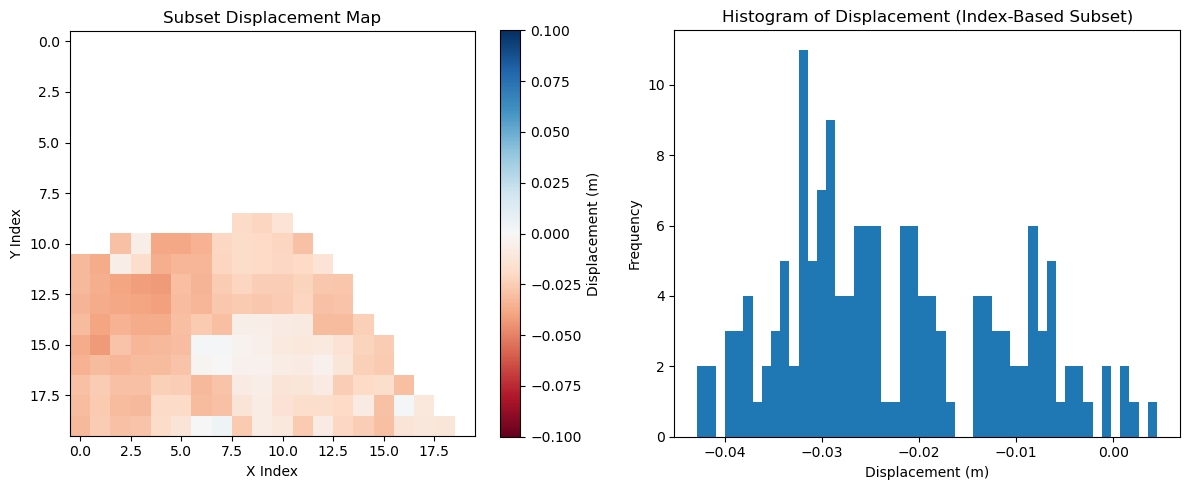

In [9]:
subset_vals = subset.values.flatten()
subset_vals = subset_vals[~np.isnan(subset_vals)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Map of the subset
im = axes[0].imshow(subset.values, cmap="RdBu", vmin=-0.1, vmax=0.1)
axes[0].set_title("Subset Displacement Map")
axes[0].set_xlabel("X Index")
axes[0].set_ylabel("Y Index")
fig.colorbar(im, ax=axes[0], orientation='vertical', label="Displacement (m)")

# Panel 2: Histogram
axes[1].hist(subset_vals, bins=50)
axes[1].set_title("Histogram of Displacement (Index-Based Subset)")
axes[1].set_xlabel("Displacement (m)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


### File Space and Chunk Layout Analysis

Building on the above section, it is important to understand how scientific data files are internally organized. Variables such as displacement or temporal coherence are divided into two-dimensional chunks, which act as independent blocks that can be selectively accessed. Because only the chunks intersecting a user’s query need to be fetched, this structure enables partial reads and reduces unnecessary data transfer. When paired with tuned I/O parameters like buffer sizes and cache settings, chunked layouts make cloud-optimized access possible, ensuring that workflows remain efficient even for very large files. This analysis of file space and chunk organization provides the structural context behind the performance gains observed during remote streaming.


The file uses a paged free-space management strategy (`H5F_FSPACE_STRATEGY_PAGE`) with a page size of about 4 MB. The raw data accounts for roughly 389 MB, while metadata contributes less than 1 MB, bringing the total file size to about 394 MB. 

In [12]:
!h5stat -S OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc

Filename: OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc
File space management strategy: H5F_FSPACE_STRATEGY_PAGE
File space page size: 4194304 bytes
Summary of file space information:
  File metadata: 917216 bytes
  Raw data: 389683119 bytes
  Amount/Percent of tracked free space: 0 bytes/0.0%
  Unaccounted space: 3664241 bytes
Total space: 394264576 bytes


**Observation**:
- **Strategy:** `H5F_FSPACE_STRATEGY_PAGE` (paged free-space management)
- **Page size:** 4,194,304 bytes (**4 MB**)
- **Raw data size:** ~389.7 MB
- **Metadata size:** ~0.9 MB
- **Total file size:** ~394.3 MB


The displacement datasets are stored in a chunked layout of `(256, 256)` with shuffle and deflate compression at level 4. This structure allows efficient partial access and reduces storage size through ~3.5–3.8x compression.  


In [15]:
!h5dump -pH OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc | grep displacement -A 10
   

   DATASET "displacement" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 8036, 9614 ) / ( 8036, 9614 ) }
      STORAGE_LAYOUT {
         CHUNKED ( 256, 256 )
         SIZE 81878337 (3.774:1 COMPRESSION)
      }
      FILTERS {
         PREPROCESSING SHUFFLE
         COMPRESSION DEFLATE { LEVEL 4 }
      }
--
   DATASET "short_wavelength_displacement" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 8036, 9614 ) / ( 8036, 9614 ) }
      STORAGE_LAYOUT {
         CHUNKED ( 256, 256 )
         SIZE 88318187 (3.499:1 COMPRESSION)
      }
      FILTERS {
         PREPROCESSING SHUFFLE
         COMPRESSION DEFLATE { LEVEL 4 }
      }


**Observation**:
- **Raw size of `displacement`:** ≈ 8036 × 9614 × 4 bytes ≈ 309 MB
- **Chunk geometry:** 256 × 256 → each uncompressed chunk = 256 × 256 × 4 bytes = 256 KiB
- **Approx. number of chunks:** ⌈8036/256⌉ × ⌈9614/256⌉ = 32 × 38 = 1216 chunks


### Why This Matters

- The displacement variable has a raw size of ~309 MB, stored in chunks of `256 × 256` (≈256 KB each).  
- With compression (~3.7:1), chunks shrink to ~70 KB on average, making them efficient to stream.  
- There are ~1200 chunks in total, so grouping them into larger blocks helps reduce overhead.  

### Implications

- Crossing chunk boundaries adds extra reads/decompression.  
- Dask/xarray should chunk in multiples of `(256, 256)` (e.g., 512×512 or 1024×1024).  
- Each task should pull MBs of data (not KBs) to balance performance and memory.  
- The 4 MB free-space paging aligns well with these access patterns.  

### The Optimization Parameters We Set

- Dask/xarray chunking: `1024 × 1024` → ~4 MB uncompressed per task, ~1–2 MB compressed.  
- Time-stacked collections keep per-time tasks small and efficient.  
- Windowed reads should align to 256-pixel boundaries to avoid partial-chunk penalties.  
- Parallelism works best with task sizes in the 1–8 MB range and worker memory in the few-GB range.  

See the [Cloud-Optimized NetCDF4/HDF5 Guide](https://guide.cloudnativegeo.org/cloud-optimized-netcdf4-hdf5/) for more details.  
